In [49]:
import os
import math
import random #to set the seed to replicate results
from datetime import datetime,timedelta #for today's date
from dateutil.relativedelta import relativedelta
import sys

import psycopg2
import psycopg2.extras
from psycopg2.extensions import AsIs

import pandas as pd 
import numpy as np #for the e_logarithmic filter (and also some other mathematical operations)
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler #for preprocessing, it scales features using statistics that are robust to outliers.
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress #for the slope and the value of Y at X=0 of the linear trend line
from scipy.optimize import curve_fit
import tsmoothie #for the Kalman filter, it is an efficient recursive filter that evaluates the state of a dynamic system starting from a series of measurements subject to noise.

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM #the two main layers of the model
from tensorflow.keras import optimizers #for the training of the model
from tensorflow.keras.models import load_model

random.seed(42)  #set the seed to replicate results

plt.style.use('ggplot')
plt.rc(
    'figure',
    autolayout=True,
    figsize=(11,4)
)

plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=20,
    titlepad=10
)

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Functions 

In [50]:
'''Function for making sequences (blocks) of test and train data'''
def building_data_sequences(data_X,data_Y, timesteps): #timesteps means how many days we consider for each block

    X=[]
    y_MPNxP = []
    for i in range(len(data_X)-timesteps+1):  #how it works: every timesteps (e.g. 10 days) a block is constituted and for each block data and true values are stored
        X.append(data_X[i:(i+timesteps),:])
        y_MPNxP.append(data_Y[i+timesteps-1])
    return np.array(X), [np.array(y_MPNxP)]

'''Function for computing the analytical parameters'''
def sir_parameters(x,y): #sir stands for slope, intercept, rvalue (actually there's also the average trend line distance or avg_tld, but it came later)

  analytical_params = linregress(x, y)
  slope = analytical_params.slope
  intercept = analytical_params.intercept
  rvalue = analytical_params.rvalue #pay attention that here we have the correlaton coefficient (so not r2 that is the coefficient of determination)
  x_trend_line = slope*x + intercept #this is computed just for the avg_tld
  avg_trend_line_distance = np.mean(np.abs(x_trend_line-y))
  return slope,intercept,rvalue**2,avg_trend_line_distance

In [51]:
'''This is the timestep which indicates the window size'''
model_case_version_time_steps= '10'
'''This is the number of periods defined in the target(MPNxP) where x is the number of periods'''
model_case_version_main_target_code='5'

#today = '20220706'
today = datetime.today().strftime('%Y%m%d') #just for names of files (for now)
print('Today is', today)

Today is 20240117


In [52]:
''' Here, we define the case name'''
case = 'EURUSD=X'
print(case)

EURUSD=X


In [53]:
'''Here, we define the list of targets we are going to work on and also the average for each target (this value is used during the training for normalization\rescaling of some analytical parameters)'''
targets =['MPN'+model_case_version_main_target_code+'P']  #this must be changed whenever tha targets change
avg_prices_list = []

In [54]:
targets

['MPN5P']

In [55]:
#1L = dispersion = 1
#4L = slope + intercept + resqr + dispersion = 1
#5L = all the weighting = 1
#new paramaters case = intercept + slope + end intercept + correlation + dispersion
slope_weighting_exponent_ratio = 1
intercept_weighting_exponent_ratio = 1
end_intercept_weighting_exponent_ratio = 0
rsqr_weighting_exponent_ratio = 1
dispersion_weighting_exponent_ratio = 3

slope_weighting_exponent_predicted_actual = 0
intercept_weighting_exponent_predicted_actual = 0
rsqr_weighting_exponent_predicted_actual = 0
dispersion_weighting_exponent_predicted_actual = 0

analytical_parametrs = str(intercept_weighting_exponent_ratio)+str(slope_weighting_exponent_ratio)+str(end_intercept_weighting_exponent_ratio)+str(rsqr_weighting_exponent_ratio)+str(dispersion_weighting_exponent_ratio)
print(analytical_parametrs)

11013


#### Model Configs

In [56]:
'''Model parameters: in order to understand, consult the original documentation (case_version_cat Tab) '''
n_epochs = 100
batch = 64
correction_n_epochs =100
correction_batch=64

'''These are the exponent used to define the number of nodes for each layer'''
twoexp_nodes_number_layer_1 = 7
twoexp_nodes_number_layer_2 = 10
twoexp_nodes_number_layer_3 = 7
twoexp_nodes_number_layer_4 = 6
twoexp_nodes_number_layer_5 = 0

lr=0.0005 #learning rate
correction_lr=0.0005

In [57]:
'''Other variables to be used during training'''

max_iterations =1#maximum number of iterations for the while loop (we will ee later in the code)
precision = 0.00000000001 #this precision is related to the quality of the compound_run_term value we want to obtain (that is representative of the quality of the model)
attenuation_factor = 0.75 #it us used in the computation of the attenuated_padding_value (see custom_loss_function)

#### DATA

In [58]:
''' Conection to PostgreSQL '''
# The credentials to conect to the database
hostname = 'database-1.ctzm0hf7fhri.eu-central-1.rds.amazonaws.com'
database = 'dyDATA_new'
username = 'postgres'
pwd = 'Proc2023awsrdspostgresql'
port_id = 5432
conn = None

#this helps to retreive the data for a particular asset from the database
asset_script="SELECT * FROM "+'\"'+"ASSET_"+case+'\"'+".features_targets_input_view WHERE features_targets_input_view."+'\"'+"cleaned_raw_features_environment_PK"+'\"'+ "= 4"
asset_script

'SELECT * FROM "ASSET_EURUSD=X".features_targets_input_view WHERE features_targets_input_view."cleaned_raw_features_environment_PK"= 4'

In [59]:
''' The active financial assets '''
# Here we select the active financial asset from the financial asset list table
try:
  with psycopg2.connect(
      host = hostname,
      dbname = database,
      user = username,
      password = pwd,
      port = port_id
  ) as conn:

    with conn.cursor(cursor_factory=psycopg2.extras.DictCursor) as cur:
        print('You are connect to the Database:',database)
        select_script = asset_script # do not forget to set to asset_script when data has been uploaded
        cur.execute(select_script)
        data = cur.fetchall()
        cols = []
        # loop to create the dataframe that contains the active financial assets
        for rec in cur.description:
            cols.append(rec[0])
        dohlcav_mpnxp_data= pd.DataFrame(data = data, columns = cols)
        print('Your SQL has executed successfully')

except Exception as error:
  print(error)

finally:
  if conn is not None:
     conn.close()

You are connect to the Database: dyDATA_new
Your SQL has executed successfully


In [60]:
if case=='TSLA':
  dohlcav_mpnxp_data = dohlcav_mpnxp_data.loc[dohlcav_mpnxp_data['cleaned_raw_features_DCP_date_current_period'] >= '2020-01-01'].reset_index(drop=True)

if case == 'EURUSD=X':
  dohlcav_mpnxp_data['cleaned_raw_features_VTCP_volume_of_transactions_current_period'] = 1
  dohlcav_mpnxp_data = dohlcav_mpnxp_data.loc[dohlcav_mpnxp_data['cleaned_raw_features_DCP_date_current_period'] >= '2020-01-01'].reset_index(drop=True)

dohlcav_mpnxp_data.head()

,cleaned_raw_features_id,cleaned_raw_features_DCP_date_current_period,calculated_features_DNCP,cleaned_raw_features_OPCP_open_price_current_period,cleaned_raw_features_HPCP_high_price_current_period,cleaned_raw_features_LPCP_low_price_current_period,cleaned_raw_features_CPCP_close_price_current_period,cleaned_raw_features_ACPCP_adjusted_close_price_current_period,cleaned_raw_features_VTCP_volume_of_transactions_current_period,cleaned_raw_features_environment_PK,calculated_targets_HPN1P,calculated_targets_LPN1P,calculated_targets_MPN1P,calculated_targets_MPN2P,calculated_targets_HPN2P,calculated_targets_LPN2P,calculated_targets_MPN3P,calculated_targets_HPN3P,calculated_targets_LPN3P,calculated_targets_MPN4P,calculated_targets_HPN4P,calculated_targets_LPN4P,calculated_targets_MPN5P,calculated_targets_HPN5P,calculated_targets_LPN5P,calculated_targets_MPN6P,calculated_targets_HPN6P,calculated_targets_LPN6P,calculated_targets_MPN7P,calculated_targets_HPN7P,calculated_targets_LPN7P,calculated_targets_MPN10P,calculated_targets_HPN10P,calculated_targets_LPN10P,calculated_targets_MPN20P,calculated_targets_HPN20P,calculated_targets_LPN20P,calculated_targets_environment_PK
0,4198,2020-01-01,43831.0,1.122083,1.122839,1.115947,1.122083,1.122083,1,4,1.122713,1.116682,1.121894,1.117606,1.122713,1.112570,1.117144,1.122713,1.112570,1.117669,1.122713,1.112570,1.117081,1.122713,1.111086,1.116383,1.122713,1.109509,1.116196,1.122713,1.108623,1.114037,1.122713,1.108623,1.111426,1.122713,1.099324,4
1,4199,2020-01-02,43832.0,1.121894,1.122713,1.116682,1.122083,1.122083,1,4,1.118068,1.112570,1.117081,1.116664,1.120825,1.112570,1.117144,1.120825,1.112570,1.116383,1.120825,1.111086,1.116196,1.120825,1.109509,1.115524,1.120825,1.108623,1.114467,1.120825,1.108623,1.113590,1.120825,1.108623,1.111006,1.120825,1.099324,4
2,4200,2020-01-03,43833.0,1.117081,1.118068,1.112570,1.117144,1.117144,1,4,1.120825,1.115810,1.116246,1.117736,1.120825,1.113487,1.116246,1.120825,1.111086,1.115692,1.120825,1.109509,1.114663,1.120825,1.108623,1.112893,1.120825,1.108623,1.113449,1.120825,1.108623,1.113530,1.120825,1.108623,1.110156,1.120825,1.099324,4
3,4201,2020-01-06,43836.0,1.116246,1.120825,1.115810,1.116196,1.116196,1,4,1.119946,1.113487,1.119582,1.116047,1.119946,1.111086,1.114663,1.119946,1.109509,1.112162,1.119946,1.108623,1.112100,1.119946,1.108623,1.112261,1.119946,1.108623,1.112966,1.119946,1.108623,1.112972,1.119946,1.107751,1.109644,1.119946,1.099324,4
4,4202,2020-01-07,43837.0,1.119582,1.119946,1.113487,1.119800,1.119800,1,4,1.116520,1.111086,1.115474,1.111834,1.116520,1.109509,1.111321,1.116520,1.108623,1.111550,1.116520,1.108623,1.111667,1.116520,1.108623,1.112162,1.116520,1.108623,1.112966,1.117194,1.108623,1.112063,1.117194,1.107751,1.109161,1.117194,1.099324,4


In [61]:
filtered_columns_1=list(dohlcav_mpnxp_data.columns[:9])#to filter out the dates columns and features columns
filtered_columns_2=[x for x in dohlcav_mpnxp_data.columns if  targets[0][3:] in x ]#feature out the main target columns

#special condition for filtering if the main target is MPN1P
if model_case_version_main_target_code=='1':
  temp=filtered_columns_2[0]
  temp_2=filtered_columns_2[1]
  filtered_columns_2[0]=filtered_columns_2[2]
  filtered_columns_2[1]=temp
  filtered_columns_2[2]=temp_2


#to add the last two constant columns to the table
filtered_columns_3=['calculated_targets_HPN1P','calculated_targets_LPN1P']

filtered_columns=filtered_columns_1+filtered_columns_2+filtered_columns_3

print(filtered_columns)

dohlcav_mpnxp_data=dohlcav_mpnxp_data[filtered_columns]

dohlcav_mpnxp_data.head()

['cleaned_raw_features_id', 'cleaned_raw_features_DCP_date_current_period', 'calculated_features_DNCP', 'cleaned_raw_features_OPCP_open_price_current_period', 'cleaned_raw_features_HPCP_high_price_current_period', 'cleaned_raw_features_LPCP_low_price_current_period', 'cleaned_raw_features_CPCP_close_price_current_period', 'cleaned_raw_features_ACPCP_adjusted_close_price_current_period', 'cleaned_raw_features_VTCP_volume_of_transactions_current_period', 'calculated_targets_MPN5P', 'calculated_targets_HPN5P', 'calculated_targets_LPN5P', 'calculated_targets_HPN1P', 'calculated_targets_LPN1P']


,cleaned_raw_features_id,cleaned_raw_features_DCP_date_current_period,calculated_features_DNCP,cleaned_raw_features_OPCP_open_price_current_period,cleaned_raw_features_HPCP_high_price_current_period,cleaned_raw_features_LPCP_low_price_current_period,cleaned_raw_features_CPCP_close_price_current_period,cleaned_raw_features_ACPCP_adjusted_close_price_current_period,cleaned_raw_features_VTCP_volume_of_transactions_current_period,calculated_targets_MPN5P,calculated_targets_HPN5P,calculated_targets_LPN5P,calculated_targets_HPN1P,calculated_targets_LPN1P
0,4198,2020-01-01,43831.0,1.122083,1.122839,1.115947,1.122083,1.122083,1,1.117081,1.122713,1.111086,1.122713,1.116682
1,4199,2020-01-02,43832.0,1.121894,1.122713,1.116682,1.122083,1.122083,1,1.116196,1.120825,1.109509,1.118068,1.112570
2,4200,2020-01-03,43833.0,1.117081,1.118068,1.112570,1.117144,1.117144,1,1.114663,1.120825,1.108623,1.120825,1.115810
3,4201,2020-01-06,43836.0,1.116246,1.120825,1.115810,1.116196,1.116196,1,1.112100,1.119946,1.108623,1.119946,1.113487
4,4202,2020-01-07,43837.0,1.119582,1.119946,1.113487,1.119800,1.119800,1,1.111667,1.116520,1.108623,1.116520,1.111086


In [62]:
dohlcav_mpnxp_data.tail()

,cleaned_raw_features_id,cleaned_raw_features_DCP_date_current_period,calculated_features_DNCP,cleaned_raw_features_OPCP_open_price_current_period,cleaned_raw_features_HPCP_high_price_current_period,cleaned_raw_features_LPCP_low_price_current_period,cleaned_raw_features_CPCP_close_price_current_period,cleaned_raw_features_ACPCP_adjusted_close_price_current_period,cleaned_raw_features_VTCP_volume_of_transactions_current_period,calculated_targets_MPN5P,calculated_targets_HPN5P,calculated_targets_LPN5P,calculated_targets_HPN1P,calculated_targets_LPN1P
840,5038,2023-03-22,45007.0,1.077424,1.080147,1.075951,1.077424,1.077424,1,1.079914,1.0929,1.072156,1.092900,1.086862
841,5039,2023-03-23,45008.0,1.087039,1.092900,1.086862,1.087039,1.087039,1,1.079914,1.0929,1.072156,1.084246,1.072156
842,5040,2023-03-24,45009.0,1.083776,1.084246,1.072156,1.076426,1.076426,1,1.079914,1.0929,1.072156,1.079600,1.074807
843,5041,2023-03-26,45011.0,1.077819,1.079600,1.074807,1.077819,1.077819,1,1.079914,1.0929,1.072156,1.081081,1.079914
844,5042,2023-03-27,45012.0,1.080030,1.081081,1.079914,1.080964,1.080964,1,1.079914,1.0929,1.072156,1.081081,1.079914


In [63]:
if model_case_version_main_target_code=='1':
  dohlcav_mpnxp_data.columns=["ID","DCP_date_current_period","DNCP_day_number_current_period","OPCP_open_price_current_period","HPCP_high_price_current_period","LPCP_low_price_current_period"
,"CPCP_close_price_current_period","ACPCP_adjusted_close_price_current_period","VTCP_volume_of_transactions_current_period","MPN"+model_case_version_main_target_code+"P_median_price_next_"+model_case_version_main_target_code+"_periods","HPN"+model_case_version_main_target_code+"P_highest_price_next_"+model_case_version_main_target_code+"_periods","LPN"+model_case_version_main_target_code+"P_lowest_price_next_"+model_case_version_main_target_code+"_periods","HPN1P_high_price_next_1_period",
"LPN1P_low_price_next_1_period"
]
else:
  dohlcav_mpnxp_data = dohlcav_mpnxp_data.rename(columns={"cleaned_raw_features_id":"ID",
                                "cleaned_raw_features_DCP_date_current_period": "DCP_date_current_period",
                                "calculated_features_DNCP":"DNCP_day_number_current_period",
                                "cleaned_raw_features_OPCP_open_price_current_period":"OPCP_open_price_current_period",
                                "cleaned_raw_features_HPCP_high_price_current_period":"HPCP_high_price_current_period",
                                "cleaned_raw_features_LPCP_low_price_current_period":"LPCP_low_price_current_period",
                                "cleaned_raw_features_CPCP_close_price_current_period": "CPCP_close_price_current_period",
                                "cleaned_raw_features_ACPCP_adjusted_close_price_current_period":"ACPCP_adjusted_close_price_current_period",
                                "cleaned_raw_features_VTCP_volume_of_transactions_current_period":"VTCP_volume_of_transactions_current_period",
                                filtered_columns_2[0]:"MPN"+model_case_version_main_target_code+"P_median_price_next_"+model_case_version_main_target_code+"_periods",
                                filtered_columns_2[1]:"HPN"+model_case_version_main_target_code+"P_highest_price_next_"+model_case_version_main_target_code+"_periods",
                                filtered_columns_2[2]:"LPN"+model_case_version_main_target_code+"P_lowest_price_next_"+model_case_version_main_target_code+"_periods",
                                filtered_columns_3[0]:"HPN1P_high_price_next_1_period",
                                filtered_columns_3[1]:"LPN1P_low_price_next_1_period",
                                })
  
dohlcav_mpnxp_data.head()

,ID,DCP_date_current_period,DNCP_day_number_current_period,OPCP_open_price_current_period,HPCP_high_price_current_period,LPCP_low_price_current_period,CPCP_close_price_current_period,ACPCP_adjusted_close_price_current_period,VTCP_volume_of_transactions_current_period,MPN5P_median_price_next_5_periods,HPN5P_highest_price_next_5_periods,LPN5P_lowest_price_next_5_periods,HPN1P_high_price_next_1_period,LPN1P_low_price_next_1_period
0,4198,2020-01-01,43831.0,1.122083,1.122839,1.115947,1.122083,1.122083,1,1.117081,1.122713,1.111086,1.122713,1.116682
1,4199,2020-01-02,43832.0,1.121894,1.122713,1.116682,1.122083,1.122083,1,1.116196,1.120825,1.109509,1.118068,1.112570
2,4200,2020-01-03,43833.0,1.117081,1.118068,1.112570,1.117144,1.117144,1,1.114663,1.120825,1.108623,1.120825,1.115810
3,4201,2020-01-06,43836.0,1.116246,1.120825,1.115810,1.116196,1.116196,1,1.112100,1.119946,1.108623,1.119946,1.113487
4,4202,2020-01-07,43837.0,1.119582,1.119946,1.113487,1.119800,1.119800,1,1.111667,1.116520,1.108623,1.116520,1.111086


In [64]:
#this variable defines the path to save the results of the LMB
model_path=case + '_DECEMBER_FIKRI'

print(model_path)
#to check the existence of the specified path so as to be sure of saving results in the right path
if os.path.exists(model_path):
  print("YES")
else:
  print("NO")

EURUSD=X_DECEMBER_FIKRI
YES


In [65]:
# dohlcav_mpnxp_data = dohlcav_mpnxp_data.replace(',','', regex=True) #remove the ',' otherwise it's impossible to deal with numbers in the dataset
dohlcav_mpnxp_data.tail(int(model_case_version_main_target_code)+1) # to visualize likely columns with NaN values in the dataset


,ID,DCP_date_current_period,DNCP_day_number_current_period,OPCP_open_price_current_period,HPCP_high_price_current_period,LPCP_low_price_current_period,CPCP_close_price_current_period,ACPCP_adjusted_close_price_current_period,VTCP_volume_of_transactions_current_period,MPN5P_median_price_next_5_periods,HPN5P_highest_price_next_5_periods,LPN5P_lowest_price_next_5_periods,HPN1P_high_price_next_1_period,LPN1P_low_price_next_1_period
839,5037,2023-03-21,45006.0,1.071915,1.078725,1.070492,1.071915,1.071915,1,1.079914,1.0929,1.072156,1.080147,1.075951
840,5038,2023-03-22,45007.0,1.077424,1.080147,1.075951,1.077424,1.077424,1,1.079914,1.0929,1.072156,1.092900,1.086862
841,5039,2023-03-23,45008.0,1.087039,1.092900,1.086862,1.087039,1.087039,1,1.079914,1.0929,1.072156,1.084246,1.072156
842,5040,2023-03-24,45009.0,1.083776,1.084246,1.072156,1.076426,1.076426,1,1.079914,1.0929,1.072156,1.079600,1.074807
843,5041,2023-03-26,45011.0,1.077819,1.079600,1.074807,1.077819,1.077819,1,1.079914,1.0929,1.072156,1.081081,1.079914
844,5042,2023-03-27,45012.0,1.080030,1.081081,1.079914,1.080964,1.080964,1,1.079914,1.0929,1.072156,1.081081,1.079914


In [66]:
''' This comprises the list of target in our datasets'''
targets_list=["MPN"+model_case_version_main_target_code+"P_median_price_next_"+model_case_version_main_target_code+"_periods",
                        "HPN"+model_case_version_main_target_code+"P_highest_price_next_"+model_case_version_main_target_code+"_periods",
                        "LPN"+model_case_version_main_target_code+"P_lowest_price_next_"+model_case_version_main_target_code+"_periods",
                        'HPN1P_high_price_next_1_period','LPN1P_low_price_next_1_period']

targets_list

['MPN5P_median_price_next_5_periods',
 'HPN5P_highest_price_next_5_periods',
 'LPN5P_lowest_price_next_5_periods',
 'HPN1P_high_price_next_1_period',
 'LPN1P_low_price_next_1_period']

In [67]:
for i in targets_list:
  if targets[0] in i:
    main_target_column=i

main_target_column

'MPN5P_median_price_next_5_periods'

In [68]:
''' What is stop target?'''
stop_target=dohlcav_mpnxp_data.index[-1]+1

In [69]:
''' Here what we do is to separate data in two parts: the first goes from the beginnig of 2020 to the end of 2021 and
it is used for training the model; the second goes from the beginning of 2022 until the end
(it dependes on the last update we did for the dataset) and it is used for testing the model.
To do that, we siply compute the size of the training set and then we use this value (later in the code) to split the dataset '''

dohlcav_mpnxp_data['DCP_date_current_period'] = pd.to_datetime(dohlcav_mpnxp_data['DCP_date_current_period']) #date values in the dataset are converted

dohlcav_mpnxp_data.head()

,ID,DCP_date_current_period,DNCP_day_number_current_period,OPCP_open_price_current_period,HPCP_high_price_current_period,LPCP_low_price_current_period,CPCP_close_price_current_period,ACPCP_adjusted_close_price_current_period,VTCP_volume_of_transactions_current_period,MPN5P_median_price_next_5_periods,HPN5P_highest_price_next_5_periods,LPN5P_lowest_price_next_5_periods,HPN1P_high_price_next_1_period,LPN1P_low_price_next_1_period
0,4198,2020-01-01,43831.0,1.122083,1.122839,1.115947,1.122083,1.122083,1,1.117081,1.122713,1.111086,1.122713,1.116682
1,4199,2020-01-02,43832.0,1.121894,1.122713,1.116682,1.122083,1.122083,1,1.116196,1.120825,1.109509,1.118068,1.112570
2,4200,2020-01-03,43833.0,1.117081,1.118068,1.112570,1.117144,1.117144,1,1.114663,1.120825,1.108623,1.120825,1.115810
3,4201,2020-01-06,43836.0,1.116246,1.120825,1.115810,1.116196,1.116196,1,1.112100,1.119946,1.108623,1.119946,1.113487
4,4202,2020-01-07,43837.0,1.119582,1.119946,1.113487,1.119800,1.119800,1,1.111667,1.116520,1.108623,1.116520,1.111086


In [70]:
dohlcav_mpnxp_data.tail()

,ID,DCP_date_current_period,DNCP_day_number_current_period,OPCP_open_price_current_period,HPCP_high_price_current_period,LPCP_low_price_current_period,CPCP_close_price_current_period,ACPCP_adjusted_close_price_current_period,VTCP_volume_of_transactions_current_period,MPN5P_median_price_next_5_periods,HPN5P_highest_price_next_5_periods,LPN5P_lowest_price_next_5_periods,HPN1P_high_price_next_1_period,LPN1P_low_price_next_1_period
840,5038,2023-03-22,45007.0,1.077424,1.080147,1.075951,1.077424,1.077424,1,1.079914,1.0929,1.072156,1.092900,1.086862
841,5039,2023-03-23,45008.0,1.087039,1.092900,1.086862,1.087039,1.087039,1,1.079914,1.0929,1.072156,1.084246,1.072156
842,5040,2023-03-24,45009.0,1.083776,1.084246,1.072156,1.076426,1.076426,1,1.079914,1.0929,1.072156,1.079600,1.074807
843,5041,2023-03-26,45011.0,1.077819,1.079600,1.074807,1.077819,1.077819,1,1.079914,1.0929,1.072156,1.081081,1.079914
844,5042,2023-03-27,45012.0,1.080030,1.081081,1.079914,1.080964,1.080964,1,1.079914,1.0929,1.072156,1.081081,1.079914


In [71]:
start_date = pd.Timestamp(str(dohlcav_mpnxp_data['DCP_date_current_period'].iloc[0])) #start date of the training set

train_end_date = pd.Timestamp('2022-12-30')#this specifies the training end date

period = str(start_date.date()) + '_' + str(train_end_date.date())

train_end_idx = dohlcav_mpnxp_data.index[dohlcav_mpnxp_data['DCP_date_current_period']==train_end_date].values[0]
train_end_idx = train_end_idx-int(model_case_version_main_target_code)

train_end_date=dohlcav_mpnxp_data.loc[train_end_idx,'DCP_date_current_period']#we move the training date in such a way that we avoid the tail values
prediction_end_date=pd.Timestamp(str(dohlcav_mpnxp_data['DCP_date_current_period'].iloc[-1]))

filename = 'proceedit '+today+' SPP-'+case+'_'+period+'_MPN'+model_case_version_main_target_code+'P_LSTM-15710760-B'+str(batch)+'E'+str(n_epochs)+'L'+str(lr)+'T'+model_case_version_time_steps+ \
            '-DOHLCAV-FTEKR_LVSP_LSTM-15710760-B'+str(batch)+'E'+str(n_epochs)+'L'+str(lr)+'T'+model_case_version_time_steps+'-PR_'+analytical_parametrs+'L0.75_AH'

print(filename)

proceedit 20240117 SPP-EURUSD=X_2020-01-01_2022-12-30_MPN5P_LSTM-15710760-B64E100L0.0005T10-DOHLCAV-FTEKR_LVSP_LSTM-15710760-B64E100L0.0005T10-PR_11013L0.75_AH


In [72]:
'''This is the mask of booleans that will be used to filter data and take just what we need (data from the beginning until the end of 2021)'''

train_mask = (dohlcav_mpnxp_data['DCP_date_current_period'] <= train_end_date)#to select data for training
prediction_mask = (dohlcav_mpnxp_data['DCP_date_current_period'] <= prediction_end_date)#to select data for prediction

In [73]:
training_size = dohlcav_mpnxp_data.loc[train_mask].shape[0] #the mask is applied and from the correspondent dataframe we take just the shape[0] (the size\the number of rows)
prediction_size = dohlcav_mpnxp_data.loc[prediction_mask].shape[0]
print('Training size: ', training_size)
print('Prediction size: ', prediction_size)

Training size:  778
Prediction size:  845


In [74]:
'''These will be used in the predictions output file (in order to know from which point starting to paste the results).'''
dates = dohlcav_mpnxp_data.iloc[int(model_case_version_time_steps)-1:,1].apply(lambda x: x.date().strftime('%Y-%m-%d')).reset_index(drop=True)
dates

0      2020-01-14
1      2020-01-15
2      2020-01-16
3      2020-01-17
4      2020-01-20
          ...    
831    2023-03-22
832    2023-03-23
833    2023-03-24
834    2023-03-26
835    2023-03-27
Name: DCP_date_current_period, Length: 836, dtype: object

In [75]:
'''Building the dataframe with just the necessary columns (removing 'id', 'uuid' and 'ACPCP_adjusted_close_price_current_period' column)'''

#pay attention here because everytime targets change, also the name of the columns change
df = dohlcav_mpnxp_data.drop(["ID","DCP_date_current_period"], axis=1)

'''Renaming columns to have a more compact and a better reading of the df'''
#pay attention here because everytime targets change, also the name of the columns change
df = df.rename(columns={"DNCP_day_number_current_period": "DNCP",
                        "OPCP_open_price_current_period":"OPCP",
                        "HPCP_high_price_current_period":"HPCP",
                        "LPCP_low_price_current_period":"LPCP",
                        "CPCP_close_price_current_period":"CPCP",
                        "ACPCP_adjusted_close_price_current_period": "ACPCP",
                        "VTCP_volume_of_transactions_current_period":"VTCP",
                        "MPN"+model_case_version_main_target_code+"P_median_price_next_"+model_case_version_main_target_code+"_periods":"MPN"+model_case_version_main_target_code+"P",
                        "HPN"+model_case_version_main_target_code+"P_highest_price_next_"+model_case_version_main_target_code+"_periods":"HPN"+model_case_version_main_target_code+"P",
                        "LPN"+model_case_version_main_target_code+"P_lowest_price_next_"+model_case_version_main_target_code+"_periods":"LPN"+model_case_version_main_target_code+"P",
                        'HPN1P_high_price_next_1_period':'hpn1p',
                        'LPN1P_low_price_next_1_period':'lpn1p'})

#df.columns = ['DNCP', 'OPCP', 'HPCP', 'LPCP', 'CPCP', 'ACPCP', 'VTCP', 'MPN1P', 'HPN1P', 'LPN1P', 'HPN1P', 'LPN1P']

df.head()

,DNCP,OPCP,HPCP,LPCP,CPCP,ACPCP,VTCP,MPN5P,HPN5P,LPN5P,hpn1p,lpn1p
0,43831.0,1.122083,1.122839,1.115947,1.122083,1.122083,1,1.117081,1.122713,1.111086,1.122713,1.116682
1,43832.0,1.121894,1.122713,1.116682,1.122083,1.122083,1,1.116196,1.120825,1.109509,1.118068,1.112570
2,43833.0,1.117081,1.118068,1.112570,1.117144,1.117144,1,1.114663,1.120825,1.108623,1.120825,1.115810
3,43836.0,1.116246,1.120825,1.115810,1.116196,1.116196,1,1.112100,1.119946,1.108623,1.119946,1.113487
4,43837.0,1.119582,1.119946,1.113487,1.119800,1.119800,1,1.111667,1.116520,1.108623,1.116520,1.111086


In [76]:
pd.set_option('display.max_columns',None)


base_target_code = 'MPN' + model_case_version_main_target_code + 'P'
base_target_column_index = df.columns.get_loc(base_target_code)

def new_target_column(target_code , shift_back_period):
  prev_target = df[target_code]
  new_target = prev_target[:-shift_back_period]
  first_dates_handling = [0] * shift_back_period
  new_target=np.concatenate((first_dates_handling,new_target))
  return new_target

#Adding multiple targets
new_target_index = base_target_column_index
for i in range(int(model_case_version_main_target_code)):
  new_target_code = 'MPN-' + str(i+1) + 'P'
  df.insert(new_target_index+1,new_target_code,new_target_column(base_target_code,i+1))
  new_target_index = new_target_index + 1
  targets.append(new_target_code)

# '''Ratio Transformation for features'''
df.insert(7,'OPCP_Ratio',df['OPCP']/df['CPCP'])
df.insert(8,'HPCP_Ratio',df['HPCP']/df['CPCP'])
df.insert(9,'LPCP_Ratio',df['LPCP']/df['CPCP'])
df.insert(10,'ACPCP_Ratio',df['ACPCP']/df['CPCP'])
df.insert(df.columns.get_loc('MPN'+model_case_version_main_target_code+'P') ,'MPN'+ model_case_version_main_target_code +'P_Ratio',df['MPN'+ model_case_version_main_target_code +'P'].shift(5)/df['CPCP'].shift(5))
df.insert(df.columns.get_loc('HPN'+model_case_version_main_target_code+'P'),'HPN'+ model_case_version_main_target_code +'P_Ratio',df['HPN'+ model_case_version_main_target_code +'P']/df['CPCP'])
df.insert(df.columns.get_loc('LPN'+model_case_version_main_target_code+'P'),'LPN'+ model_case_version_main_target_code +'P_Ratio',df['LPN'+ model_case_version_main_target_code +'P']/df['CPCP'])
df.insert(df.columns.get_loc('hpn1p')+1,'hpn1p_Ratio',df['hpn1p']/df['CPCP'])
df.insert(df.columns.get_loc('lpn1p')+1,'lpn1p_Ratio',df['lpn1p']/df['CPCP'])

df = df.iloc[int(model_case_version_main_target_code):]

df.head()

,DNCP,OPCP,HPCP,LPCP,CPCP,ACPCP,VTCP,OPCP_Ratio,HPCP_Ratio,LPCP_Ratio,ACPCP_Ratio,MPN5P_Ratio,MPN5P,MPN-1P,MPN-2P,MPN-3P,MPN-4P,MPN-5P,HPN5P_Ratio,HPN5P,LPN5P_Ratio,LPN5P,hpn1p,hpn1p_Ratio,lpn1p,lpn1p_Ratio
5,43838.0,1.115573,1.116520,1.111086,1.115474,1.115474,1,1.000089,1.000938,0.996067,1.0,0.995543,1.112025,1.111667,1.112100,1.114663,1.116196,1.117081,1.000781,1.116345,0.993858,1.108623,1.112223,0.997086,1.109509,0.994652
6,43839.0,1.111444,1.112223,1.109509,1.111321,1.111321,1,1.000111,1.000812,0.998369,1.0,0.994754,1.112979,1.112025,1.111667,1.112100,1.114663,1.116196,1.005284,1.117194,0.997572,1.108623,1.112100,1.000701,1.108623,0.997572
7,43840.0,1.110926,1.112100,1.108623,1.111111,1.111111,1,0.999833,1.000890,0.997761,1.0,0.997780,1.113449,1.112979,1.112025,1.111667,1.112100,1.114663,1.005474,1.117194,0.997882,1.108758,1.114467,1.003020,1.111408,1.000267
8,43843.0,1.111655,1.114467,1.111408,1.111667,1.111667,1,0.999989,1.002519,0.999767,1.0,0.996330,1.113090,1.113449,1.112979,1.112025,1.111667,1.112100,1.004972,1.117194,0.996477,1.107751,1.114579,1.002619,1.110556,0.999001
9,43844.0,1.113449,1.114579,1.110556,1.113573,1.113573,1,0.999889,1.000903,0.997290,1.0,0.992737,1.112754,1.113090,1.113449,1.112979,1.112025,1.111667,1.003251,1.117194,0.994771,1.107751,1.116345,1.002489,1.112025,0.998610


In [77]:
for target in targets:
  avg_prices_list.append(df[target].astype(float).mean())

avg_prices_list

[1.1222101769166668,
 1.1222479784642858,
 1.1222862951309525,
 1.1223276639702382,
 1.1223708573035713,
 1.1224151045654762]

In [78]:
'''?????????????????'''

main_target_code_integer = int(model_case_version_main_target_code)

#this is calculate the period day number to be used in the training section
dncp_train = dohlcav_mpnxp_data[train_mask]['DNCP_day_number_current_period'].replace(',', '', regex=True)[int(model_case_version_time_steps)-1+main_target_code_integer:]
dncp_train = dncp_train.astype(int).to_numpy()

span_dncp_train=dncp_train[-1] - dncp_train[0] + 1

positions_day_number_train= dncp_train-dncp_train[0]+1
positions_day_number_train

array([   1,    2,    3,    4,    7,    8,    9,   10,   11,   14,   15,
         16,   17,   18,   21,   22,   23,   24,   25,   28,   29,   30,
         31,   32,   35,   36,   37,   38,   39,   42,   43,   44,   45,
         46,   49,   50,   51,   52,   53,   56,   57,   58,   59,   60,
         63,   64,   65,   66,   67,   69,   70,   71,   72,   73,   76,
         77,   78,   79,   80,   83,   84,   85,   86,   87,   90,   91,
         92,   93,   94,   97,   98,   99,  100,  101,  104,  105,  106,
        107,  108,  111,  112,  113,  114,  115,  118,  119,  120,  121,
        122,  125,  126,  127,  128,  129,  132,  133,  134,  135,  136,
        139,  140,  141,  142,  143,  146,  147,  148,  149,  150,  153,
        154,  155,  156,  157,  160,  161,  162,  163,  164,  167,  168,
        169,  170,  171,  174,  175,  176,  177,  178,  181,  182,  183,
        184,  185,  188,  189,  190,  191,  192,  195,  196,  197,  198,
        199,  202,  203,  204,  205,  206,  209,  2

In [79]:
int(model_case_version_time_steps) - 1 + main_target_code_integer

14

In [80]:
#this is calculate the period day number to be used in the prediction section
dncp = dohlcav_mpnxp_data['DNCP_day_number_current_period'].replace(',','', regex=True)[int(model_case_version_time_steps)-1+main_target_code_integer:]
dncp = dncp.astype(int).to_numpy()
span_dncp=dncp[-1] - dncp[0] + 1
positions_day_number = dncp-dncp[0]+1
positions_day_number

array([   1,    2,    3,    4,    7,    8,    9,   10,   11,   14,   15,
         16,   17,   18,   21,   22,   23,   24,   25,   28,   29,   30,
         31,   32,   35,   36,   37,   38,   39,   42,   43,   44,   45,
         46,   49,   50,   51,   52,   53,   56,   57,   58,   59,   60,
         63,   64,   65,   66,   67,   69,   70,   71,   72,   73,   76,
         77,   78,   79,   80,   83,   84,   85,   86,   87,   90,   91,
         92,   93,   94,   97,   98,   99,  100,  101,  104,  105,  106,
        107,  108,  111,  112,  113,  114,  115,  118,  119,  120,  121,
        122,  125,  126,  127,  128,  129,  132,  133,  134,  135,  136,
        139,  140,  141,  142,  143,  146,  147,  148,  149,  150,  153,
        154,  155,  156,  157,  160,  161,  162,  163,  164,  167,  168,
        169,  170,  171,  174,  175,  176,  177,  178,  181,  182,  183,
        184,  185,  188,  189,  190,  191,  192,  195,  196,  197,  198,
        199,  202,  203,  204,  205,  206,  209,  2

In [81]:
len(positions_day_number)

831

In [82]:
'''The padding point value is calculated for computing the value at the end of the trend line. We'll see better during the training and the application of vertical padding '''
padding_point = positions_day_number[0]
padding_point

1

### Pretreatment

In [83]:
#seperate training dataset and apply pre-treament only on the training dataset
train_dataset=df.iloc[main_target_code_integer:train_end_idx+1,:]

train_dataset.head()

,DNCP,OPCP,HPCP,LPCP,CPCP,ACPCP,VTCP,OPCP_Ratio,HPCP_Ratio,LPCP_Ratio,ACPCP_Ratio,MPN5P_Ratio,MPN5P,MPN-1P,MPN-2P,MPN-3P,MPN-4P,MPN-5P,HPN5P_Ratio,HPN5P,LPN5P_Ratio,LPN5P,hpn1p,hpn1p_Ratio,lpn1p,lpn1p_Ratio
10,43845.0,1.112966,1.116345,1.112025,1.113090,1.113090,1,0.999889,1.002925,0.999044,1.0,0.996909,1.109779,1.112754,1.113090,1.113449,1.112979,1.112025,1.003687,1.117194,0.994675,1.107162,1.117194,1.003687,1.112979,0.999900
11,43846.0,1.115270,1.117194,1.112979,1.115400,1.115400,1,0.999883,1.001608,0.997829,1.0,1.001491,1.109644,1.109779,1.112754,1.113090,1.113449,1.112979,0.999193,1.114500,0.989514,1.103704,1.114500,0.999193,1.108758,0.994045
12,43847.0,1.113800,1.114500,1.108758,1.113958,1.113958,1,0.999859,1.000487,0.995332,1.0,1.002104,1.108648,1.109644,1.109779,1.112754,1.113090,1.113449,0.998221,1.111976,0.989376,1.102123,1.110494,0.996891,1.107751,0.994428
13,43850.0,1.109521,1.110494,1.107751,1.109459,1.109459,1,1.000055,1.000933,0.998460,1.0,1.001280,1.108356,1.108648,1.109644,1.109779,1.112754,1.113090,1.002268,1.111976,0.992381,1.101006,1.111976,1.002268,1.108648,0.999268
14,43851.0,1.109644,1.111976,1.108648,1.109693,1.109693,1,0.999956,1.002057,0.999058,1.0,0.999264,1.104816,1.108356,1.108648,1.109644,1.109779,1.112754,1.000566,1.110321,0.991135,1.099856,1.109779,1.000078,1.107162,0.997719


In [84]:
# Pretreatment Train

train_df_array=train_dataset.to_numpy(dtype='float64')

#application of logarithmic detrending
if not (train_df_array < 0).any():
    print('logarithmic detrending applied')
    train_df_array = np.log(train_df_array)


print('--------- Logatihmic Transform ---------')
#print(pd.DataFrame(train_df_array, columns=train_dataset.columns, index=train_dataset.index))

kalman_train=True#not applying kalman Filter


'''Preprocessing consists, in this case, to transform the dataset through 3 filters: Kalman, E_logrithmic and RobustScaler (in this order)'''
if kalman_train: #necessary to deal with filter results
  '''Application of the Kalman filter (rounding data)'''
  kalman_smoother=tsmoothie.KalmanSmoother(component='level_trend',  component_noise={'level':0.1, 'trend':0.1}) #values for Kalman filters parameters
                                                                                                                  #are taken from an example in the original code
                                                                                                                  #of the library
  temp_df=pd.DataFrame(train_df_array,columns=train_dataset.columns)
  for i in range(len(temp_df.columns)): #this is the more convenient way I've found to apply the filter
    kalman_smoother.smooth(temp_df[temp_df.columns[i]])
    train_df_array[:,i] = kalman_smoother.smooth_data

print('--------- Kalman Smooth ---------')
#print(pd.DataFrame(train_df_array, columns=train_dataset.columns, index=train_dataset.index))
pd.DataFrame(train_df_array, columns=train_dataset.columns, index=train_dataset.index)


#fitting the robust scaler onn both the features and target column separately for the training dataset
train_robust_scaler_features= RobustScaler().fit(train_df_array[:,:12])
train_robust_scaler_target=RobustScaler().fit(train_df_array[:,12:12+int(model_case_version_main_target_code)+1])

#performing transform on the features
train_df_features=train_robust_scaler_features.transform(train_df_array[:,:12])
#performing transform on the target
train_df_target=train_robust_scaler_target.transform(train_df_array[:,12:12+int(model_case_version_main_target_code)+1])


logarithmic detrending applied
--------- Logatihmic Transform ---------


--------- Kalman Smooth ---------


In [85]:
df_array=df.to_numpy(dtype='float64')


# df_array = df_array[5:]
#applying logarithmic detrending to the prediction/full dataset
if not (df_array < 0).any():
    df_array = np.log(df_array)

kalman_predict=True
if kalman_predict:
  '''Preprocessing consists, in this case, to transform the dataset through 3 filters: Kalman, E_logrithmic and RobustScaler (in this order)'''

  '''Application of the Kalman filter (rounding data)'''
  kalman_smoother=tsmoothie.KalmanSmoother(component='level_trend',  component_noise={'level':0.1, 'trend':0.1}) #values for Kalman filters parameters
                                                                                                                  #are taken from an example in the original code
                                                                                                                  #of the library
  temp_df=pd.DataFrame(df_array,columns=df.columns)
  for i in range(len(df.columns)): #this is the more convenient way I've found to apply the filter
    kalman_smoother.smooth(temp_df[temp_df.columns[i]])
    df_array[:,i] = kalman_smoother.smooth_data

#robust scaler transform on the features
prediction_df_features=train_robust_scaler_features.transform(df_array[:,:12])
#robust scaler transform on the target
prediction_df_targets=train_robust_scaler_target.transform(df_array[:,12:12+int(model_case_version_main_target_code)+1])

In [86]:
'''Creating the input blocks for the models. The timestep value must be changed according to the targets and dataset we are working with'''
X_train, y_train =building_data_sequences(train_df_features,train_df_target,timesteps=int(model_case_version_time_steps))
X_predict,y_predict=building_data_sequences(prediction_df_features,prediction_df_targets,timesteps=int(model_case_version_time_steps))#see Functions section above;
#X_test, y_test = building_data_sequences(test_data, timesteps=int(model_case_version_time_steps))

print(X_train.shape)
print(X_predict.shape)

(764, 10, 12)
(831, 10, 12)


### Train Configurations

In [87]:
'''In this section, we're going to define some variables that will be useful during the training and testing of the model'''

input_shape=((X_train).shape[1],(X_train).shape[2])
print("Input shape obtained is:",input_shape)

'''We need actual values (true values) to compute some analytical parameters during the training'''
df_actual = df.iloc[int(model_case_version_time_steps)-1:,:].reset_index(drop=True)
print(df_actual)

actuals_cols = [] #simply put the targets columns into a list (in order to be iterated during training)
for target in targets:
  actuals_cols.append(np.array(df_actual[target].astype(float)))

actuals_cols

Input shape obtained is: (10, 12)
        DNCP      OPCP      HPCP      LPCP      CPCP     ACPCP  VTCP  \
0    43851.0  1.109644  1.111976  1.108648  1.109693  1.109693     1   
1    43852.0  1.108586  1.109779  1.107162  1.108561  1.108561     1   
2    43853.0  1.109755  1.110321  1.103704  1.109644  1.109644     1   
3    43854.0  1.105534  1.106085  1.102123  1.105522  1.105522     1   
4    43857.0  1.102633  1.103997  1.101006  1.102536  1.102536     1   
..       ...       ...       ...       ...       ...       ...   ...   
826  45007.0  1.077424  1.080147  1.075951  1.077424  1.077424     1   
827  45008.0  1.087039  1.092900  1.086862  1.087039  1.087039     1   
828  45009.0  1.083776  1.084246  1.072156  1.076426  1.076426     1   
829  45011.0  1.077819  1.079600  1.074807  1.077819  1.077819     1   
830  45012.0  1.080030  1.081081  1.079914  1.080964  1.080964     1   

     OPCP_Ratio  HPCP_Ratio  LPCP_Ratio  ACPCP_Ratio  MPN5P_Ratio     MPN5P  \
0      0.999956    1.0

[array([1.1048159 , 1.1026331 , 1.1022563 , 1.1022563 , 1.1022928 ,
        1.1033874 , 1.10435   , 1.10435   , 1.10347055, 1.0998317 ,
        1.0974481 , 1.0946907 , 1.0919415 , 1.0909599 , 1.0875949 ,
        1.0845987 , 1.0840108 , 1.0830246 , 1.0809642 , 1.0808474 ,
        1.0809642 , 1.0838581 , 1.0855641 , 1.0881748 , 1.090358  ,
        1.09992812, 1.1052777 , 1.1139083 , 1.11510965, 1.1185682 ,
        1.1223849 , 1.1316506 , 1.1332858 , 1.1316506 , 1.1259005 ,
        1.1184932 , 1.11597605, 1.1088687 , 1.09773162, 1.08871258,
        1.0792805 , 1.0770175 , 1.0792805 , 1.0824854 , 1.088957  ,
        1.1012245 , 1.1028155 , 1.1028155 , 1.1002739 , 1.09279835,
        1.084434  , 1.084387  , 1.0841801 , 1.0863662 , 1.0895145 ,
        1.0921084 , 1.0931351 , 1.0927409 , 1.091572  , 1.0897044 ,
        1.0866966 , 1.0863543 , 1.08565753, 1.0843987 , 1.0823683 ,
        1.0823683 , 1.0823683 , 1.0831655 , 1.0843723 , 1.0889688 ,
        1.0904293 , 1.0904293 , 1.0901321 , 1.08

In [88]:
'''??????????????'''
'''this indicates the index from which we start to replace the actual target with the predicted target to be used in the prediction section'''
stop_actual=stop_target-int(model_case_version_time_steps)+1-main_target_code_integer
stop_actual

831

In [89]:
best_models_path = model_path + '/best_models/' #this path is used just to make everything more orderly

### Train

In [90]:
df_cpcp_train=df.iloc[(int(model_case_version_time_steps)-1):train_end_idx+1,:].reset_index(drop=True)
CPCP_cols_train=[]
CPCP_cols_train.append(np.array(df_cpcp_train['CPCP'].astype(float)))

In [91]:
best_prediction_run=0
best_correction_run=0

prediction_runs=100
correction_runs=1

past_corr_train_stat=True
past_corr_pred_stat=True

apply_correction_lstm=True
apply_vertical_swing_corr=True

In [92]:
'''This is the custom loss function we defined in order to apply a sort of padding during the training of the model. It consists in a normal mean squared error loss fnuction except for the application of
a multiplicative factor on the prediction of the model'''

def custom_loss_function(attenuated_padding_value):

  def padding_loss_function(y_true, y_pred):

    y_pred = tf.multiply(y_pred, attenuated_padding_value) #this is the multiplication between the predictions and the attenuated_padding_value

    squared_difference = tf.square(y_true - y_pred)

    return tf.reduce_mean(squared_difference, axis=-1) #mse

  return padding_loss_function

intercepts_and_slopes = {'intercepts': [],
                         'slopes':[],
                         'end_intercepts':[]
                         }

In [93]:
'''This is about a part that must be inserted in the analytical paramters file and which is referred to the weights that are used to compute the compound_run_term (see later in the code)'''

weights_df = pd.DataFrame([None, None, None, None, None, None, None, None, slope_weighting_exponent_ratio, intercept_weighting_exponent_ratio, end_intercept_weighting_exponent_ratio, rsqr_weighting_exponent_ratio, dispersion_weighting_exponent_ratio,
                           slope_weighting_exponent_predicted_actual, intercept_weighting_exponent_predicted_actual, rsqr_weighting_exponent_predicted_actual, dispersion_weighting_exponent_predicted_actual, None, None, None, None,None]).T

weights_df=weights_df.rename({0:'weights'})
weights_df=weights_df.rename(columns={0:'slope_predicted_calculated_target_ratio_versus_period',
                           1: 'intercept_predicted_calculated_target_ratio_versus_period',
                           2: 'end_intercept_predicted_calculated_target_ratio_versus_period',
                           3: 'rsqr_predicted_calculated_target_ratio_versus_period',
                           4: 'average_tld_predicted_calculated_target_ratio_versus_period',
                           5: 'slope_predicted_versus_calculated_target',
                           6: 'intercept_predicted_versus_calculated_target',
                           7: 'rsqr_predicted_versus_calculated_target',
                           8: 'average_tld_predicted_versus_calculated_target',
                           9: 'normalized_slope_predicted_calculated_target_ratio_versus_period',
                           10: 'normalized_intercept_predicted_calculated_target_ratio_versus_period',
                           11: 'normalized_end_intercept_predicted_calculated_target_ratio_versus_period',
                           12: 'normalized_rsqr_predicted_calculated_target_ratio_versus_period',
                           13: 'rescaled_normalized_average_tld_predicted_calculated_target_ratio_versus_period',
                           14: 'normalized_slope_predicted_versus_calculated_target',
                           15: 'rescaled_normalized_intercept_predicted_versus_calculated_target',
                           16: 'normalized_rsqr_predicted_versus_calculated_target',
                           17: 'rescaled_normalized_average_tld_predicted_versus_calculated_target',
                           18: 'compound_run_term',
                           19: 'best_run',
                           20: 'adjusted_compound_run_term',
                           21: 'padding_correction_factor',
                           22: 'padding_correction_factor_attenuation'
                           })

weights_df.columns

Index(['slope_predicted_calculated_target_ratio_versus_period',
       'intercept_predicted_calculated_target_ratio_versus_period',
       'end_intercept_predicted_calculated_target_ratio_versus_period',
       'rsqr_predicted_calculated_target_ratio_versus_period',
       'average_tld_predicted_calculated_target_ratio_versus_period',
       'slope_predicted_versus_calculated_target',
       'intercept_predicted_versus_calculated_target',
       'rsqr_predicted_versus_calculated_target',
       'average_tld_predicted_versus_calculated_target',
       'normalized_slope_predicted_calculated_target_ratio_versus_period',
       'normalized_intercept_predicted_calculated_target_ratio_versus_period',
       'normalized_end_intercept_predicted_calculated_target_ratio_versus_period',
       'normalized_rsqr_predicted_calculated_target_ratio_versus_period',
       'rescaled_normalized_average_tld_predicted_calculated_target_ratio_versus_period',
       'normalized_slope_predicted_versus_calcula

In [94]:
'''The creation of the new analytical parameters output file '''

new_weights_df = pd.DataFrame([slope_weighting_exponent_ratio, intercept_weighting_exponent_ratio,
                               end_intercept_weighting_exponent_ratio, rsqr_weighting_exponent_ratio,
                               dispersion_weighting_exponent_ratio, slope_weighting_exponent_predicted_actual,
                               intercept_weighting_exponent_predicted_actual, end_intercept_weighting_exponent_ratio,
                               rsqr_weighting_exponent_predicted_actual, dispersion_weighting_exponent_predicted_actual,
                               None, None, None, None]).T
new_weights_df = new_weights_df.rename({0:'weights'})
new_weights_df = new_weights_df.rename(columns={0:'normalized_trend_slope',
                               1: 'normalized_trend_intercept',
                               2: 'normalized_trend_end_intercept',
                               3: 'normalized_trend_rsqr',
                               4: 'rescaled_normalized_trend_dispersion',
                               5: 'trend_slope_weighting_exponent',
                               6: 'trend_intercept_weighting_exponent',
                               7: 'trend_end_intercept_weighting_exponent',
                               8: 'trend_rsqr_weighting_exponent',
                               9: 'trend_dispersion_weighting_exponent',
                               10: 'adjusted_compound_run_value',
                               11: 'number_of_runs_performed',
                               12: 'best_run_number',
                               13: 'best_model_.h5_file_link'
                               })

new_weights_df.columns

Index(['normalized_trend_slope', 'normalized_trend_intercept',
       'normalized_trend_end_intercept', 'normalized_trend_rsqr',
       'rescaled_normalized_trend_dispersion',
       'trend_slope_weighting_exponent', 'trend_intercept_weighting_exponent',
       'trend_end_intercept_weighting_exponent',
       'trend_rsqr_weighting_exponent', 'trend_dispersion_weighting_exponent',
       'adjusted_compound_run_value', 'number_of_runs_performed',
       'best_run_number', 'best_model_.h5_file_link'],
      dtype='object')

In [95]:
#this prepare the correction lstm table consisting of three columns:period_day_number, raw_predicted_targets,actual
def preprare_correction_lstm_table(period_day_number,raw_predicted_targets,volume,actual):
  correction_lstm_table=pd.DataFrame()
  correction_lstm_table['period_day_number']=period_day_number[int(model_case_version_main_target_code):]
  correction_lstm_table['raw_predicted_targets']=raw_predicted_targets[int(model_case_version_main_target_code):]
  new = (actual/raw_predicted_targets)
  print(len(new[:-int(model_case_version_main_target_code)]))
  print(new)
  correction_lstm_table['new_feature'] = new[:-int(model_case_version_main_target_code)]
  print(correction_lstm_table['new_feature'])
  correction_lstm_table['volume'] = volume[int(model_case_version_main_target_code):]
  correction_lstm_table['actual_raw_predited_ratio']=(actual/raw_predicted_targets)[int(model_case_version_main_target_code):]
  return correction_lstm_table

#this prepare the correction lstm table consisting of three columns:period_day_number, raw_predicted_targets,actual
def preprare_correction_lstm_table_predict(period_day_number,raw_predicted_targets,volume,actual,lstm_scaler_feat,lstm_scaler_target):
  correction_lstm_table=pd.DataFrame()
  correction_lstm_table['period_day_number']=period_day_number[int(model_case_version_main_target_code):]
  correction_lstm_table['raw_predicted_targets']=raw_predicted_targets[int(model_case_version_main_target_code):]
  new = (actual/raw_predicted_targets)
  correction_lstm_table['new_feature'] = new[:-int(model_case_version_main_target_code)]
  correction_lstm_table['volume'] = volume[int(model_case_version_main_target_code):]
  correction_lstm_table['actual_raw_predited_ratio']=(actual/raw_predicted_targets)[int(model_case_version_main_target_code):]
  correction_lstm_table=correction_lstm_table.to_numpy()
  train_df_lstm_features=lstm_scaler_feat.transform(correction_lstm_table[:,:2])
  train_df_lstm_target=lstm_scaler_target.transform(correction_lstm_table[:,2].reshape(-1,1))
  final_correction_lstm=np.concatenate((train_df_lstm_features,train_df_lstm_target),axis=1)
  return final_correction_lstm

#this prepare the correction lstm table consisting of three columns:period_day_number, raw_predicted_targets,actual
def preprare_correction_lstm_table_train(period_day_number, raw_predicted_targets,volume,actual):
  correction_lstm_table_temp=pd.DataFrame()
  correction_lstm_table_temp['period_day_number']=period_day_number[int(model_case_version_main_target_code):]
  correction_lstm_table_temp['raw_predicted_targets']=raw_predicted_targets[int(model_case_version_main_target_code):]
  new = (actual/raw_predicted_targets)
  # print(len(new[:-int(model_case_version_main_target_code)]))
  # print(new)
  # sys.exit()
  correction_lstm_table_temp['new_feature'] = new[:-int(model_case_version_main_target_code)]
  # print(correction_lstm_table['new_feature'])
  correction_lstm_table_temp['volume'] = volume[int(model_case_version_main_target_code):]
  correction_lstm_table_temp['actual_raw_predited_ratio']=(actual/raw_predicted_targets)[int(model_case_version_main_target_code):]
  # pd.set_option('display.max_rows', None)
  #print(correction_lstm_table_temp)
  pd.reset_option('display.max_rows')
  correction_lstm_table=correction_lstm_table_temp.to_numpy()
  correction_lstm_table = correction_lstm_table[int(model_case_version_main_target_code):]
  robust_scaler_LSTM_features= RobustScaler().fit(correction_lstm_table[:,:4])
  robust_scaler_LSTM_target=RobustScaler().fit(correction_lstm_table[:,4].reshape(-1,1))
  train_df_lstm_features=robust_scaler_LSTM_features.transform(correction_lstm_table[:,:4])
  train_df_lstm_target=robust_scaler_LSTM_target.transform(correction_lstm_table[:,4].reshape(-1,1))
  final_correction_lstm=np.concatenate((train_df_lstm_features,train_df_lstm_target),axis=1)
  return final_correction_lstm,robust_scaler_LSTM_features,robust_scaler_LSTM_target,correction_lstm_table_temp['actual_raw_predited_ratio'][int(model_case_version_time_steps)-1:].to_numpy()

#this creates the data_sequences(time widows) for the correction LSTM
def correction_data_sequences(data, timesteps): #timesteps means how many days we consider for each block
    X=[]
    y_MPNxP = []
    for i in range(len(data)-timesteps+1):  #how it works: every timesteps (e.g. 10 days) a block is constituted and for each block data and true values are stored
        X.append(data[i:(i+timesteps),:4])
        y_MPNxP.append(data[i+timesteps-1,4])
    return np.array(X),np.array(y_MPNxP)

In [98]:
'''This is the core part, where the the model is defined and trained. In particular, we're using an approach defined by us as 'Multiple Run' because what we do is to iterate the training of our model for a certain amount of times,
until we do not obtain the best one (according to a certain value of course) over all the others. More in details: we train a model and for this model we compute the compound_run_term (that is the value used to eveluate the quality
of the model itself). Of course, at the beginning the first model we obtain is the best one. However, in the next iteration, we train another model (with the same parameters, layers, etc.) and also for this second model we compute
the compound_run_term (to assess its quality). If the compound_run_term of the second model is better ('better' in this case means that is closer to 1) than the best model we've obtained so far (so the first one), then the second
model becomes the new best model. So, we proceed in this way, until either we reach the maximum number of iterations or we obtain a compound_run_term with a certain precision. This approach was born because of an instability problem
that affects our model'''

after_training_predictions = []

for target in range(len(targets)): #for each target
  analytical_parameters = {
    'slope_predicted_calculated_target_ratio_versus_period':[], #slope of the trend line obtained by considering the ratio between predicted values and actual values.
    'intercept_predicted_calculated_target_ratio_versus_period':[], #intercept of the trend line obtained by considering the ratio between predicted values and actual values.
    'end_intercept_predicted_calculated_target_ratio_versus_period':[],
    'rsqr_predicted_calculated_target_ratio_versus_period':[], #r2 of the trend line obtained by considering the ratio between predicted values and actual values.
    'average_tld_predicted_calculated_target_ratio_versus_period':[], #average trend line distance of the trend line obtained by considering the ratio between predicted values and actual values.

    'slope_predicted_versus_calculated_target':[], #slope of the trend line obtained by considering the actual values as x and the predicted values as y.
    'intercept_predicted_versus_calculated_target':[], #intercept of the trend line obtained by considering the actual values as x and the predicted values as y.
    'rsqr_predicted_versus_calculated_target':[], #r2 of the trend line obtained by considering the actual values as x and the predicted values as y.
    'average_tld_predicted_versus_calculated_target':[], #average trend line distance of the trend line obtained by considering the actual values as x and the predicted values as y.

    'normalized_slope_predicted_calculated_target_ratio_versus_period': [],
    'normalized_intercept_predicted_calculated_target_ratio_versus_period':[],
    'normalized_end_intercept_predicted_calculated_target_ratio_versus_period':[],
    'normalized_rsqr_predicted_calculated_target_ratio_versus_period': [],
    'rescaled_normalized_average_tld_predicted_calculated_target_ratio_versus_period': [],

    'normalized_slope_predicted_versus_calculated_target': [],
    'rescaled_normalized_intercept_predicted_versus_calculated_target': [],
    'normalized_rsqr_predicted_versus_calculated_target': [],
    'rescaled_normalized_average_tld_predicted_versus_calculated_target': [],

    'compound_run_term': [],
    'best_run': [],
    'adjusted_compound_run_term':[],
    'padding_correction_factor':[],
    'padding_correction_factor_attenuation':[],
    'absolute_difference_normalized_intercept': [],
    'vertical_padding_correction_factor':[],
    'train_vertical_trend_slope':[]
    }
  
  new_analytical_parameters = {
    'normalized_trend_slope':[],
    'normalized_trend_intercept':[],
    'normalized_trend_end_intercept':[],
    'normalized_trend_rsqr':[],
    'rescaled_normalized_trend_dispersion':[],

    'trend_slope_weighting_exponent':[],
    'trend_intercept_weighting_exponent':[],
    'trend_end_intercept_weighting_exponent':[],
    'trend_rsqr_weighting_exponent':[],
    'trend_dispersion_weighting_exponent':[],

    'adjusted_compound_run_value':[],
    'number_of_runs_performed': [],
    'best_run_number':[],
    'best_model_.h5_file_link':[],
    'best_correction_model_.h5_file_link':[]

    }
  
  '''Inzialization of some values'''
  y_target = y_train #the current target we're considering
  diff = 1e3 #this is used to determine whether the current best model is still the best or not.
  best_run = -1 #this is used to take trace of the best iteration so far
  adjusted_compound_run_term = 1e3 #it is initialized with a very big value just to iterate at least one time the while loop
  iteration = 0 #counter for iterations
  attenuated_padding_value = 0.8
  #attenuated_padding_value = 1 #initial value for the attenuating padding value
  best_model_adjusted_compound_run_term=0#initial value of the best_model adjusted compound run term
  # last_best_model_run_number=0# initial value for the last best model run number
  # current_best_model_run_number=0#initial value for the current best model run number
  last_best_model_path_h5='dummy.h5'#initial dummy value for the last best model path
  last_best_correction_model_path_h5='correction.h5'
  iteration_adj_compount_run = {'iteration': [], 'adjusted_compound_run_term':[], 'attenuated_padding_value':[]}

  max_iterations=max(prediction_runs,correction_runs) if prediction_runs!=0 or correction_runs!=0 else 1
  #print('Max iterations: ', max_iterations)

  while abs(adjusted_compound_run_term - 1.0) >= precision and iteration <= max_iterations:
    print('----------------------------')
    print('Iteration', iteration, 'for target',targets[target])
    print('Attenuated padding value', attenuated_padding_value)
    print('adjusted_compound_run_term ', adjusted_compound_run_term)
    iteration_adj_compount_run['iteration'].append(iteration)
    iteration_adj_compount_run['attenuated_padding_value'].append(attenuated_padding_value)

    if prediction_runs==0:
      # default_path_prediction=(best_models_path+targets[target]+'/proceedit '+today+' SPP-'+case+'_20000103-20221130_MPN'+model_case_version_main_target_code+'P_LSTM15_DOHLCAV-10-S-KER-710760-64-100-0.0005-10-'+str(analytical_parametrs)+'L'+str(attenuation_factor)+'_ME - Best model for '+targets[target]+'run_'+str(best_prediction_run)+'.h5')
      default_path_prediction=(best_models_path+targets[target]+'/proceedit 20231230 SPP-AAPL_20000103-20221130_MPN5P_LSTM15_DOHLCAV-10-S-KER-710760-64-100-0.0005-10-11013L0.75_ME - Best model for MPN5Prun_0.h5')
      # default_path_prediction=(best_models_path+targets[target]+'/proceedit 20230826 SPP-^GSPC_20200102-20230118_MPN5P_LSTM-15710760-B64E100L0.0005T8-DOHLCAV-FTEKR_LVSP_LSTM-15710760-B64E100L0.0005T8-PR_11011L0.75_AH - Best model for MPN7Prun_0.h5') #TSLA
      prediction_model=load_model(default_path_prediction,compile=False)
      #print(default_path_prediction)

    else:
      if iteration < prediction_runs:
        #print(y_target)
        '''The layers of the model (see case_version_cat Tab)'''
        tf.keras.backend.clear_session()
        prediction_model=tf.keras.Sequential()
        prediction_model.add(LSTM(2**twoexp_nodes_number_layer_1,input_shape=input_shape,return_sequences=True))
        prediction_model.add(LSTM(2**twoexp_nodes_number_layer_2, return_sequences=True))
        prediction_model.add(LSTM(2**twoexp_nodes_number_layer_3))
        prediction_model.add(Dense(2**twoexp_nodes_number_layer_4))
        prediction_model.add(Dense(int(model_case_version_main_target_code)+1))
        prediction_model.compile(optimizer = optimizers.Adam(learning_rate = lr), loss = custom_loss_function(attenuated_padding_value))

        '''Training of the model'''
        print('\n')
        print(' ----------- Training prediction model started -----------')
        print('\n')
        prediction_model.fit(X_train, y_target, batch_size=batch, epochs=100, verbose=0)

    '''Computation of the predictions'''
    train_predictions=prediction_model.predict(X_train) #predictions for training data
    train_predictions = train_robust_scaler_target.inverse_transform(train_predictions) #convert prediction first by inverting the Robust scaler transformation and then the e_logarithmic one.
    train_predictions = np.exp(train_predictions)
    train_prediction = [a[:1] for a in train_predictions]
    train_array = np.concatenate(train_prediction)

    multiple_run_predictions = train_array
    actual = actuals_cols[0][:len(multiple_run_predictions)]
    pred_actual_vs_date_ratio = train_array / actual # why date?
    
    _, _, _, pred_actual_vs_date_ratio_dispersion= sir_parameters(positions_day_number_train,pred_actual_vs_date_ratio)
    #print("pred_actual_vs_date_ratio_dispersion",pred_actual_vs_date_ratio_dispersion)

    _, _, _, pred_vs_actual_dispersion= sir_parameters(actual,train_array)
    #print("pred_actual_dispersion",pred_vs_actual_dispersion)

    '''implementation of the correction phases for the LSTM corrected_predicted_targets'''
    '''PHASE 1 CORRECTION'''
    #vertical_correction
    raw_predicted_targets = train_array
    train_raw_targets_ratio = raw_predicted_targets/actual

    if apply_vertical_swing_corr:
      print('\n')
      print(' ----------- Training correction model started -----------')
      print('\n')
      train_raw_trend_slope, train_raw_trend_intercept, _, train_raw_trend_dispersion= sir_parameters(positions_day_number_train,train_raw_targets_ratio)
      #print('train_raw_trend_slope:',train_raw_trend_slope)
      #print('train_raw_trend_intercept:',train_raw_trend_intercept)
      #print('train_raw_trend_dispersion',train_raw_trend_dispersion)

      vertical_padding_correction_factor = 1/train_raw_trend_intercept
      #print("vertical_padding_correction_factor:",vertical_padding_correction_factor)
      corrected_train_raw_targets_ratios = train_raw_targets_ratio * vertical_padding_correction_factor
      #print("corrected_train_raw_targets_ratios", corrected_train_raw_targets_ratios[:10])
      train_vertical_corrected_targets = corrected_train_raw_targets_ratios * actual#this is the formula for vertical padding
      #print("back_vertical_corrected_targets", train_vertical_corrected_targets[:10])

      swing_padding_correction_factors = []
      train_vertical_targets_ratios=train_vertical_corrected_targets/actual
      train_vertical_trend_slope, train_vertical_trend_intercept, _, train_vertical_trend_dispersion= sir_parameters(positions_day_number_train, train_vertical_targets_ratios)

      for i in positions_day_number_train:
        swing_padding_correction_factor = 1 / (1 + i * train_vertical_trend_slope)
        swing_padding_correction_factors.append(swing_padding_correction_factor)

      #print('swing_padding_correction_factors',swing_padding_correction_factors[:10])
      #print('period_day_numbers', positions_day_number_train[:10])

      swing_targets_ratios = train_raw_targets_ratio* vertical_padding_correction_factor*swing_padding_correction_factors
      swing_predicted_targets = swing_targets_ratios * actual

      #print('swing_predicted_targets: ', swing_predicted_targets[:10])

    else:
      swing_predicted_targets=raw_predicted_targets

    '''implementation of correction lstm'''
    if True:
      volume = df_actual['VTCP']
      correction_lstm_table,lstm_robust_feat,lstm_robust_target,actual_correct=preprare_correction_lstm_table_train(positions_day_number_train,swing_predicted_targets,volume,actual)
      correction_train_data=correction_lstm_table
      X_correction_train, y_correction_train =correction_data_sequences(correction_train_data, int(model_case_version_time_steps))
      #print(correction_train_data)
      #print(X_correction_train)
      # sys.exit()
      correction_input_shape=((X_correction_train).shape[1],(X_correction_train).shape[2])
      #print(correction_input_shape)
      if correction_runs==0:
        # default_path_correction=(best_models_path+targets[target]+'/proceedit '+today+' SPP-'+case+'_20000103-20221130_MPN'+model_case_version_main_target_code+'P_LSTM15_DOHLCAV-10-S-KER-710760-64-100-0.0005-10-'+str(analytical_parametrs)+'L'+str(attenuation_factor)+'_ME - Best model for '+targets[target]+'run_'+str(best_correction_run)+'correction_model.h5')
        default_path_correction=(best_models_path+targets[target]+'/proceedit 20230827 SPP-TSLA_20200102-20230531_MPN5P_LSTM-15710760-B64E100L0.0005T8-DOHLCAV-FTEKR_LVSP_LSTM-15710760-B64E100L0.0005T8-PR_11011L0.75_DM - Best model for MPN5Prun_5correction_model.h5') #TSLA
        correction_model=load_model(default_path_correction,compile=False)
      else:
        if  iteration < correction_runs:
          '''correction lstm implementation'''
          correction_model= tf.keras.Sequential()
          correction_model.add(LSTM(2**twoexp_nodes_number_layer_1,input_shape=correction_input_shape,return_sequences=True))
          correction_model.add(LSTM(2**twoexp_nodes_number_layer_2, return_sequences=True))
          correction_model.add(LSTM(2**twoexp_nodes_number_layer_3))
          correction_model.add(Dense(2**twoexp_nodes_number_layer_4))
          correction_model.add(Dense(2**twoexp_nodes_number_layer_5))
          correction_model.compile(optimizer = optimizers.Adam(learning_rate =correction_lr), loss = custom_loss_function(attenuated_padding_value))
          correction_model.fit(X_correction_train, y_correction_train, batch_size=correction_batch, epochs=100, verbose=0)

      LSTM_corrections=correction_model.predict(X_correction_train)
      #print("raw_LSTM_corrections",LSTM_corrections[:10])
      LSTM_corrections=lstm_robust_target.inverse_transform(LSTM_corrections.reshape(-1,1))
      #print("transformed_LSTM_corrections",LSTM_corrections[:10])
      LSTM_corrections=LSTM_corrections.reshape(1,-1)[0]
      # actual_corrections= correction_lstm_table['actual_raw_predited_ratio'][int(model_case_version_time_steps)-1:].to_numpy()
      compare_corrections=lstm_robust_target.inverse_transform(correction_lstm_table[:,2][int(model_case_version_time_steps)-1 + int(model_case_version_main_target_code):].reshape(1,-1))
      actual_corrections=actual_correct
      corrected_predicted_targets=np.multiply(swing_predicted_targets[int(model_case_version_time_steps)-1 + (2*int(model_case_version_main_target_code)):],LSTM_corrections)
      #print("LSTM_corrections",LSTM_corrections[:10])
      #print("raw_predicted_targets_for_LSTM",swing_predicted_targets[int(model_case_version_time_steps)-1 + (2*int(model_case_version_main_target_code)):][:10])
      #print("corrected_predicted_targets",corrected_predicted_targets[:10])
      _, _, _, correction_dispersion= sir_parameters(actual_corrections[int(model_case_version_main_target_code):],LSTM_corrections)
      #print("pred_vs_actual_correction_dispersion",correction_dispersion)
      # plt.figure(figsize=(10,10))
      # a, b = np.polyfit(actual_corrections,LSTM_corrections, 1)
      # plt.scatter(actual_corrections, LSTM_corrections, color='purple')
      # plt.plot(actual_corrections, a*actual_corrections+b,color='steelblue', linewidth=2)
      # plt.title('predicted_vs_actual_correction_plot')
      # plt.show()
      period_day_number_temp=positions_day_number_train[int(model_case_version_time_steps)-1 + (2*int(model_case_version_main_target_code)):]
      period_day_number=period_day_number_temp-period_day_number_temp[0]+1
      actual_moving_average=actual[int(model_case_version_time_steps)-1 + (2*int(model_case_version_main_target_code)):]
    else:
      period_day_number=positions_day_number_train
      corrected_predicted_targets=swing_predicted_targets
      actual_moving_average=actual

    if past_corr_train_stat:
      ''' Implementation of last padding correction'''
      last_padding_correction_factors = []
      last_padding_correction_factors.append(1)
      last_padding_correction_factors.append(1)
      last_padding_correction_factors.append(1)
      last_padding_correction_factors.append(1)
      # last_padding_correction_factors.append(1)
      # last_padding_correction_factors.append(1)
      for i in range(4,len(period_day_number)):
        last_padding_correction_factors.append(((actual_moving_average[i-1]+actual_moving_average[i-2]+actual_moving_average[i-3]+actual_moving_average[i-4])/4)/((corrected_predicted_targets[i-1]+corrected_predicted_targets[i-2]+corrected_predicted_targets[i-3]+corrected_predicted_targets[i-4])/4))

      print(len(last_padding_correction_factors))
      # initial_last_ratio=swing_targets_ratios
      # initial_last_ratio=LSTM_corrections
      initial_last_ratio=corrected_predicted_targets/actual_moving_average

      last_targets_ratios = initial_last_ratio * last_padding_correction_factors
      last_slope,last_start_intercept,_,last_dispersion=sir_parameters(period_day_number,last_targets_ratios)
      last_predicted_targets = last_targets_ratios*actual_moving_average

      '''
      print('last_padding_correction_factors:',last_padding_correction_factors[:10])
      print('last_targets_ratios:',last_targets_ratios[:10])
      print('last_slope:', last_slope)
      print('last_start_intercept:',last_start_intercept)
      print('last_dispersion:',last_dispersion)
      '''
      #print('last_predicted_targets:',last_predicted_targets[:10])
      print()


    else:
      last_predicted_targets=corrected_predicted_targets

    '''Computation of the analytical parameter values '''
    predicted_actual_ratio = (last_predicted_targets /actual_moving_average)
    slope_first, intercept_first, r_squared_first, avg_tld_first = sir_parameters(period_day_number, predicted_actual_ratio) # computation of the analytical parameters values for the ratio graph (see Functions section above for more details)
    slope_second, intercept_second, r_squared_second, avg_tld_second = sir_parameters(actual_moving_average, last_predicted_targets) # computation of the analytical parameters values for the actual vs predicted graph (see Functions section above for more details)

    # end_intercept_first = slope_first * padding_point + intercept_first
    end_intercept_first = slope_first * positions_day_number_train[-1] + intercept_first##CONFIRM THESE

    if end_intercept_first < 0:    # end_intercept shouldn't be negative condition
       end_intercept_first = 0.1

    '''
    print(' Predicted actual ratio', predicted_actual_ratio) #Added by me just to check the ratio
    print(' Intercept', intercept_first)
    print(' Slope', slope_first)
    print(' End Intercept', end_intercept_first)
    print(' Postion day number',padding_point)
    '''
    '''Just adding each value to the correspondent list'''
    analytical_parameters['slope_predicted_calculated_target_ratio_versus_period'].append(slope_first)
    analytical_parameters['intercept_predicted_calculated_target_ratio_versus_period'].append(intercept_first)
    analytical_parameters['end_intercept_predicted_calculated_target_ratio_versus_period'].append(end_intercept_first)
    analytical_parameters['rsqr_predicted_calculated_target_ratio_versus_period'].append(r_squared_first)
    analytical_parameters['average_tld_predicted_calculated_target_ratio_versus_period'].append(avg_tld_first)
    analytical_parameters['slope_predicted_versus_calculated_target'].append(slope_second)
    analytical_parameters['intercept_predicted_versus_calculated_target'].append(intercept_second)
    analytical_parameters['rsqr_predicted_versus_calculated_target'].append(r_squared_second)
    analytical_parameters['average_tld_predicted_versus_calculated_target'].append(avg_tld_second)
  
    '''Now, we normalized\rescaled the analytical parameters values according the our reference values (that is 1).This is why we add 1 to some values or we divide for the aevrage value of that specific targets.
     Afterwards, we put the values in the correpsoondent lists. '''
    norm_slope_ratio = slope_first+1
    norm_intercept_ratio = intercept_first #I added this line
    norm_end_intercept_ratio = end_intercept_first #I added this line
    norm_rsqr_ratio = r_squared_first+1
    resc_norm_avg_tld_ratio = (avg_tld_first)+1 #here you can see the avg_price_list that we computeed at the beginning of the code
    resc_norm_inter_predact = (intercept_second)+1
    resc_norm_avg_tld_predact = (avg_tld_second)+1

    analytical_parameters['normalized_slope_predicted_calculated_target_ratio_versus_period'].append(norm_slope_ratio)
    analytical_parameters['normalized_intercept_predicted_calculated_target_ratio_versus_period'].append(norm_intercept_ratio) #I changed this line
    analytical_parameters['normalized_end_intercept_predicted_calculated_target_ratio_versus_period'].append(norm_end_intercept_ratio) #I changed this line
    analytical_parameters['normalized_rsqr_predicted_calculated_target_ratio_versus_period'].append(norm_rsqr_ratio)
    analytical_parameters['rescaled_normalized_average_tld_predicted_calculated_target_ratio_versus_period'].append(resc_norm_avg_tld_ratio)
    analytical_parameters['normalized_slope_predicted_versus_calculated_target'].append(slope_second)
    analytical_parameters['rescaled_normalized_intercept_predicted_versus_calculated_target'].append(resc_norm_inter_predact)
    analytical_parameters['normalized_rsqr_predicted_versus_calculated_target'].append(r_squared_second)
    analytical_parameters['rescaled_normalized_average_tld_predicted_versus_calculated_target'].append(resc_norm_avg_tld_predact)
    analytical_parameters['vertical_padding_correction_factor'].append(vertical_padding_correction_factor)
    analytical_parameters['train_vertical_trend_slope'].append(train_vertical_trend_slope)
    #Here we append the new analytical parameters
    new_analytical_parameters['normalized_trend_slope'].append(norm_slope_ratio)
    new_analytical_parameters['normalized_trend_intercept'].append(norm_intercept_ratio)
    new_analytical_parameters['normalized_trend_end_intercept'].append(norm_end_intercept_ratio)
    new_analytical_parameters['normalized_trend_rsqr'].append(norm_rsqr_ratio)
    new_analytical_parameters['rescaled_normalized_trend_dispersion'].append(resc_norm_avg_tld_ratio)

    new_analytical_parameters['trend_slope_weighting_exponent'].append(slope_weighting_exponent_ratio)
    new_analytical_parameters['trend_intercept_weighting_exponent'].append(intercept_weighting_exponent_ratio)
    new_analytical_parameters['trend_end_intercept_weighting_exponent'].append(end_intercept_weighting_exponent_ratio)
    new_analytical_parameters['trend_rsqr_weighting_exponent'].append(rsqr_weighting_exponent_ratio)
    new_analytical_parameters['trend_dispersion_weighting_exponent'].append(dispersion_weighting_exponent_ratio)

    '''Here, there's the computation of the compound_run_term. The idea is, in fact, to multiply all the normalized\rescaled analytical parameters among themselves. In addition to that, each value is weighted with a certain exponent.
    The best model is considered as the one whose compound_run_term is the closest to our rederence value (that is 1)'''
    compound_run_term = (norm_slope_ratio)**slope_weighting_exponent_ratio * (norm_intercept_ratio)**intercept_weighting_exponent_ratio * (norm_end_intercept_ratio)**end_intercept_weighting_exponent_ratio * (norm_rsqr_ratio)**rsqr_weighting_exponent_ratio * (resc_norm_avg_tld_ratio)**dispersion_weighting_exponent_ratio * (slope_second)**(slope_weighting_exponent_predicted_actual) * (resc_norm_inter_predact)**(intercept_weighting_exponent_predicted_actual) * (r_squared_second)**(rsqr_weighting_exponent_predicted_actual) * (resc_norm_avg_tld_predact)**(dispersion_weighting_exponent_predicted_actual)

    analytical_parameters['compound_run_term'].append(compound_run_term)

    '''The adjusted_compound_run term is the version of the compound_run_term that can be used for comparing compound run terms of different cases. Remember to change them according to the weights you're working with'''
    #adjusted_compound_run_term = (compound_run_term)**(8/(slope_weighting_exponent_ratio+intercept_weighting_exponent_ratio+rsqr_weighting_exponent_ratio+dispersion_weighting_exponent_ratio+slope_weighting_exponent_predicted_actual+intercept_weighting_exponent_predicted_actual+rsqr_weighting_exponent_predicted_actual+dispersion_weighting_exponent_predicted_actual))
    adjusted_compound_run_term = (compound_run_term)
    print(' Adjusted Compound run term:', adjusted_compound_run_term)
    iteration_adj_compount_run['adjusted_compound_run_term'].append(adjusted_compound_run_term)
  
    analytical_parameters['adjusted_compound_run_term'].append(adjusted_compound_run_term)
    new_analytical_parameters['adjusted_compound_run_value'].append(adjusted_compound_run_term)
    new_analytical_parameters['number_of_runs_performed'].append(max_iterations)

    '''This is te if branch in which the best model is determined'''
    if abs(adjusted_compound_run_term - 1) < diff: #if the compound_run_term of the current model is nearer to one than the compound_run_term of the best model, then we have a new best model
      # last_best_model_run_number=current_best_model_run_number
      # current_best_model_run_number=iteration
      analytical_parameters['best_run'].append(iteration) #store the best run so far
      new_analytical_parameters['best_run_number'].append(iteration)
      diff = abs(adjusted_compound_run_term - 1) #store the new difference (for successive comparisons)
      best_run = iteration

      #change the value for the best_run (in such a way it works also if we are in the else branch)
      if prediction_runs==0:
        current_best_model_path_h5=default_path_prediction
      else:
        best_prediction_run=iteration
        if os.path.exists(last_best_model_path_h5):#checks the exitence of the last best saved model
          os.remove(last_best_model_path_h5)#deletes the previous best saved model
        prediction_model.save(best_models_path+targets[target]+'/proceedit '+today+' SPP-'+case+'_20000103-20221130_MPN'+model_case_version_main_target_code+'P_LSTM15_DOHLCAV-10-S-KER-710760-64-100-0.0005-10-'+str(analytical_parametrs)+'L'+str(attenuation_factor)+'_ME - Best model for '+targets[target]+'run_'+str(iteration)+'.h5') #save the best model
        prediction_model.save_weights(best_models_path+targets[target]+'/proceedit '+today+' SPP-'+case+'_20000103-20221130_MPN'+model_case_version_main_target_code+'P_LSTM15_DOHLCAV-10-S-KER-710760-64-100-0.0005-10-'+str(analytical_parametrs)+'L'+str(attenuation_factor)+'_ME - Best model for '+targets[target]+'run_'+str(iteration)+'weights.h5')
        current_best_model_path_h5=(best_models_path+targets[target]+'/proceedit '+today+' SPP-'+case+'_20000103-20221130_MPN'+model_case_version_main_target_code+'P_LSTM15_DOHLCAV-10-S-KER-710760-64-100-0.0005-10-'+str(analytical_parametrs)+'L'+str(attenuation_factor)+'_ME - Best model for '+targets[target]+'run_'+str(iteration)+'.h5')
      if correction_runs==0:
        current_best_correction_model_path_h5="No"
      else:
          best_correction_run=iteration
          if os.path.exists(last_best_correction_model_path_h5):#checks the exitence of the last best saved model
            os.remove(last_best_correction_model_path_h5)#deletes the previous best saved model
          correction_model.save(best_models_path+targets[target]+'/proceedit '+today+' SPP-'+case+'_20000103-20221130_MPN'+model_case_version_main_target_code+'P_LSTM15_DOHLCAV-10-S-KER-710760-64-100-0.0005-10-'+str(analytical_parametrs)+'L'+str(attenuation_factor)+'_ME - Best model for '+targets[target]+'run_'+str(iteration)+'correction_model.h5') #save the best model
          correction_model.save_weights(best_models_path+targets[target]+'/proceedit '+today+' SPP-'+case+'_20000103-20221130_MPN'+model_case_version_main_target_code+'P_LSTM15_DOHLCAV-10-S-KER-710760-64-100-0.0005-10-'+str(analytical_parametrs)+'L'+str(attenuation_factor)+'_ME - Best model for '+targets[target]+'run_'+str(iteration)+'correction_model_weights.h5') #save the best model
          current_best_correction_model_path_h5=(best_models_path+targets[target]+'/proceedit '+today+' SPP-'+case+'_20000103-20221130_MPN'+model_case_version_main_target_code+'P_LSTM15_DOHLCAV-10-S-KER-710760-64-100-0.0005-10-'+str(analytical_parametrs)+'L'+str(attenuation_factor)+'_ME - Best model for '+targets[target]+'run_'+str(iteration)+'correction_model.h5')
        # model.save(best_models_path+targets[target]+'/proceedit '+today+' SPP-'+case+'_200001-202207_MPN'+model_case_version_main_target_code+'P_LSTM15_DOHLCAV-10-S-KER-710760-64-100-0.0005-10-'+str(analytical_parametrs)+'L'+str(attenuation_factor)+'_ME - Best model for '+targets[target]+'.h5') #save the best model
        # path_h5=(best_models_path+targets[target]+'/proceedit '+today+' SPP-'+case+'_200001-202207_MPN'+model_case_version_main_target_code+'P_LSTM15_DOHLCAV-10-S-KER-710760-64-100-0.0005-10-'+str(analytical_parametrs)+'L'+str(attenuation_factor)+'_ME - Best model for '+targets[target]+'.h5')
      after_training_predictions = []
      after_training_predictions.append(last_predicted_targets)
      new_analytical_parameters['best_model_.h5_file_link'].append(current_best_model_path_h5)
      new_analytical_parameters['best_correction_model_.h5_file_link'].append(current_best_correction_model_path_h5)

      intercepts_and_slopes['intercepts'].clear()
      intercepts_and_slopes['intercepts'].append(intercept_first)
      intercepts_and_slopes['slopes'].clear()
      intercepts_and_slopes['slopes'].append(slope_first)
      intercepts_and_slopes['end_intercepts'].clear()
      intercepts_and_slopes['end_intercepts'].append(end_intercept_first)
      best_model_intercept_first = intercept_first   #save the the intercept for the best model
      best_model_slope_first = slope_first     #save the the slope for the best model
      best_model_end_intercept_first = end_intercept_first #save the the end intercept for the best model
      best_model_adjusted_compound_run_term=adjusted_compound_run_term
      #print(' Predictions during training:', multiple_run_predictions)

    else: #otherwise, we simply take trace of the best_run so far
      analytical_parameters['best_run'].append(best_run)
      new_analytical_parameters['best_run_number'].append(best_run)
      new_analytical_parameters['best_model_.h5_file_link'].append(current_best_model_path_h5)
      new_analytical_parameters['best_correction_model_.h5_file_link'].append(current_best_correction_model_path_h5)


    last_best_model_path_h5=current_best_model_path_h5
    last_best_correction_model_path_h5=current_best_correction_model_path_h5
    print(' Best model so far: ', best_run)
    print(' Best Model Adjusted compound run term:', best_model_adjusted_compound_run_term) #Just to print the best model compound run term
    #print(' Best Model Intercept:', best_model_intercept_first)
    #print(' Best model Slope:', best_model_slope_first)
    #print(' Best model end Intercept:', best_model_end_intercept_first)

    '''The following block of lines is related to the way we compute the attenuated_padding_value (for the custom loss function). In fact, according to the position of this block, we can have two approaches:

          - if the block is inside the if branch (the one where the best model is determined), then we are in the B approach: the attenuated_padding_value is computed according to the best model obtained so far
          - if the block is outside the if branch (the one where the best model is determined), then we are in the L approach: the attenuated_padding_value is computed according to the last model obtained so far

    So in order to switch from an approach to the other, you can just cut the following 5 lines of code and paste them in the position you desire.'''
    intercept = intercept_first
    slope = slope_first
    padding_ratio_value = slope * padding_point + intercept #here we have the padding point we computed at the beginning
    padding_value = 1/padding_ratio_value
    attenuated_padding_value = ((padding_value-1)*attenuation_factor)+1
    #formula for computing the attenuated_padding_value.. we have eliminated the -1 after paddinf_value
    #print(' padding_ratio_value',padding_ratio_value) #I added these print here to check the calculation before the next iteration
    #print(' padding_value',padding_value) #I added these print here to check the calculation before the next iteration
    #print(' Attenuated padding value at end',attenuated_padding_value)

    if ((attenuated_padding_value< 0.8) or (attenuated_padding_value> 1.2)): #the attenuated_padding_value shouldn't be negative and shouldn't exceed 1
        attenuated_padding_value = 1

    #print(' Attenuated padding value at end after the limit',attenuated_padding_value)
    print()

    '''Appending the values referred to the padding'''
    #analytical_parameters['padding_correction_factor'].append(padding_value)
    #analytical_parameters['padding_correction_factor_attenuation'].append(attenuated_padding_value)
    '''Appending the values referred to the padding'''
    analytical_parameters['padding_correction_factor'].append(padding_value)
    analytical_parameters['padding_correction_factor_attenuation'].append(attenuated_padding_value)

    analytical_parameters['absolute_difference_normalized_intercept'].append(abs(intercept_first-1)) #this value is used for certain graphs (I don't know if it is still relevant for our analysis)

    #print(analytical_parameters)

    '''Here , we store the analytical parameters file inside the loop (and not at the end when we have all the results) because in this way we can monitor step by step where we are. Of course, the file is overwritten everytime .'''
    analytical_params_df = pd.DataFrame(analytical_parameters)
    analytical_params_df.to_csv(best_models_path+targets[target]+'/proceedit '+today+' '+case+'_20000103-20221130_MPN'+model_case_version_main_target_code+'P_LSTM15_DOHLCAV-10-S-KER-710760-64-100-0.0005-10-'+str(analytical_parametrs)+'L'+str(attenuation_factor)+'_'+str(prediction_runs)+'_'+str(correction_runs)+'_DM - Analytical parameters.csv')
    new_analytical_params_df = pd.DataFrame(new_analytical_parameters)
    new_analytical_params_df.to_csv(best_models_path+targets[target]+'/proceedit '+today+' '+case+'_20000103-20221130_MPN'+model_case_version_main_target_code+'P_LSTM15_DOHLCAV-10-S-KER-710760-64-100-0.0005-10-'+str(analytical_parametrs)+'L'+str(attenuation_factor)+'_'+str(prediction_runs)+'_'+str(correction_runs)+'_DM - New Analytical parameters.csv')
    iteration += 1


  '''Computation of slope and intercept for the best model predcitions'''
  last_model_predicted_actual_ratio = (last_predicted_targets/actual_moving_average)
  #best_model_predicted_actual_ratio = upload_predictions / actual
  last_model_slope_first, last_model_intercept_first, last_model_r_squared_first, last_model_avg_tld_first = sir_parameters(period_day_number, last_model_predicted_actual_ratio)
  #print('Last Model Intercept:', last_model_intercept_first)
  #print('Last model Slope:', last_model_slope_first)
  print('Best Model Intercept:', best_model_intercept_first)
  print('Best model Slope:', best_model_slope_first)
  print('Best model End Intercept:', best_model_end_intercept_first)
  print('The Predictions:', last_predicted_targets)

  '''Saving the final analytical parameters file for a specific target'''
  analytical_params_df = pd.concat([weights_df, analytical_params_df])
  analytical_params_df.to_csv(best_models_path+targets[target]+'/proceedit '+today+' '+case+'_20000103-20221130_MPN'+model_case_version_main_target_code+'P_LSTM15_DOHLCAV-10-S-KER-710760-64-100-0.0005-10-'+str(analytical_parametrs)+'L'+str(attenuation_factor)+'_'+str(prediction_runs)+'_'+str(correction_runs)+'_DM - Analytical parameters.csv')
  new_analytical_params_df = pd.concat([new_weights_df, new_analytical_params_df])
  new_analytical_params_df.to_csv(best_models_path+targets[target]+'/proceedit '+today+' '+case+'_20000103-20221130_MPN'+model_case_version_main_target_code+'P_LSTM15_DOHLCAV-10-S-KER-710760-64-100-0.0005-10-'+str(analytical_parametrs)+'L'+str(attenuation_factor)+'_'+str(prediction_runs)+'_'+str(correction_runs)+'_DM - New Analytical parameters.csv')
  break


----------------------------
Iteration 0 for target MPN5P
Attenuated padding value 0.8
adjusted_compound_run_term  1000.0


2024-01-17 11:18:43.697599: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.00MiB (rounded to 16777216)requested by op StatelessRandomNormalV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-01-17 11:18:43.697650: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-01-17 11:18:43.697671: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 30, Chunks in use: 30. 7.5KiB allocated for chunks. 7.5KiB in use in bin. 456B client-requested in use in bin.
2024-01-17 11:18:43.697685: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2024-01-17 11:18:43.697697: 

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomNormalV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[4096,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomNormalV2] name: 

,adjusted_compound_run_term,attenuated_padding_value
iteration,,
0,1.004735,1.000000
1,1.005007,0.999981
2,1.005007,0.999987


<Axes: xlabel='iteration'>

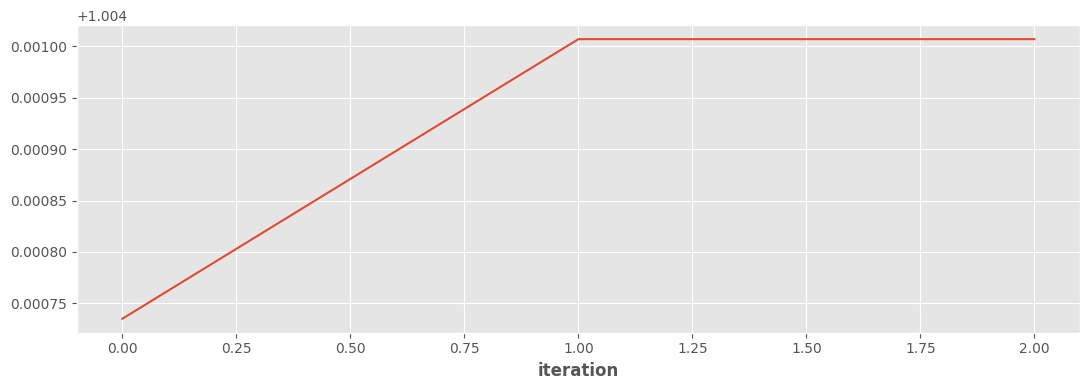

In [ ]:
iteration_adj_compount_run = pd.DataFrame(iteration_adj_compount_run)

iteration_adj_compount_run.to_csv('iteration_adj_compount_run_df.csv', index=False)

iteration_adj_compount_run_df = pd.read_csv('iteration_adj_compount_run_df.csv',index_col='iteration')

display(iteration_adj_compount_run_df.head())

iteration_adj_compount_run_df['adjusted_compound_run_term'].plot()